## 프로젝트 : CutMix 또는 Mixup 비교실험

### 1. Augmentation을 적용한 데이터셋 만들기

In [23]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
import os

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label


In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image,label, img_size=224, batch_size=16,num_classes=120):
    labels=[]
    
    for i in range(batch_size):
        label_a=label[i]
        if len(label_a.shape)==0:
             label_a= tf.one_hot(label_a, num_classes)
    
        labels.append(label_a)
        
    labels=tf.reshape(tf.stack(labels),(batch_size, num_classes))
    return image, labels

In [13]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset_cutmix(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_cutmix:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        print('cutmix')
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        print('onehot')
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        print('')
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def apply_normalize_on_dataset_mixup(ds, is_test=False, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_mixup:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        print('cutmix')
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        print('onehot')
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        print('')
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [14]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

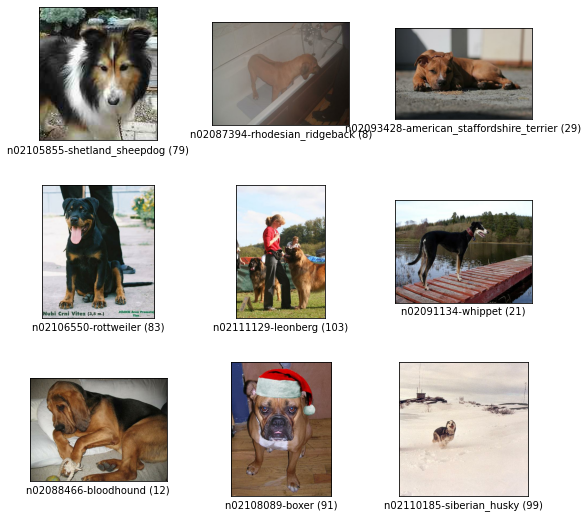

In [15]:
fig = tfds.show_examples(ds_train,ds_info)

### 2. 모델 만들기
앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용

In [16]:
## 그냥 Resnet50
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

힌트: 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해주세요

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset_cutmix(ds_train, with_cutmix=False)
ds_train_aug_cutmix = apply_normalize_on_dataset_cutmix(ds_train,with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset_mixup(ds_train,with_mixup=True)
ds_test = apply_normalize_on_dataset_cutmix(ds_test, is_test = True)

onehot

cutmix

cutmix

onehot


tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.6347656  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.36523438 

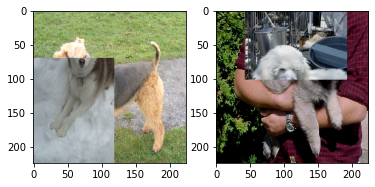

In [18]:
for i, (image, label) in enumerate(ds_train_aug_cutmix.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)
print(label_a)

plt.subplot(1,2,2)
plt.imshow(image_b)
print(label_b)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)


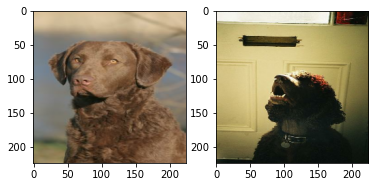

In [20]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)
print(label_a)

plt.subplot(1,2,2)
plt.imshow(image_b)
print(label_b)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)


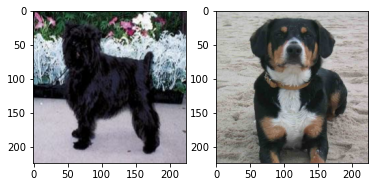

In [21]:
for i, (image, label) in enumerate(ds_test.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)
print(label_a)

plt.subplot(1,2,2)
plt.imshow(image_b)
print(label_b)

In [26]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


checkpoint_path = "training_no_aug1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback_no_aug = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    callbacks=[cp_callback_no_aug],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
  2/750 [..............................] - ETA: 48s - loss: 5.2814 - accuracy: 0.0312   WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0430s vs `on_train_batch_end` time: 0.0862s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.1981 - accuracy: 0.4499WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0043s vs `on_test_batch_end` time: 0.0294s). Check your callbacks.


750/750 [==============================] - 111s 149ms/step - loss: 2.1981 - accuracy: 0.4499 - val_loss: 3.2972 - val_accuracy: 0.2119
Epoch 2/10
750/750 [==============================] - 115s 153ms/step - loss: 0.7765 - accuracy: 0.7820 - val_loss: 1.1396 - val_accuracy: 0.6659
Epoch 3/10
750/750 [==============================] - 113s 150ms/step - loss: 0.2984 - accuracy: 0.9288 - val_loss: 1.0025 - val_accuracy: 0.7094
Epoch 4/10
750/750 [==============================] - 127s 170ms/step - loss: 0.1221 - accuracy: 0.9810 - val_loss: 0.9253 - val_accuracy: 0.7355
Epoch 5/10
750/750 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9958
Epoch 00005: saving model to training_no_aug1/cp-0005.ckpt
750/750 [==============================] - 124s 166ms/step - loss: 0.0505 - accuracy: 0.9958 - val_loss: 0.9303 - val_accuracy: 0.7352
Epoch 6/10
750/750 [==============================] - 126s 167ms/step - loss: 0.0231 - accuracy: 0.9983 - val_loss: 0.9226 - val_accuracy

In [27]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


checkpoint_path = "training_cutmix1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback_cutmix = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)


history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    callbacks=[cp_callback_cutmix],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/10
  2/750 [..............................] - ETA: 1:25 - loss: 5.0938 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0465s vs `on_train_batch_end` time: 0.0910s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8216 - accuracy: 0.2112WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0311s). Check your callbacks.


750/750 [==============================] - 116s 154ms/step - loss: 3.8216 - accuracy: 0.2112 - val_loss: 3.6329 - val_accuracy: 0.1774
Epoch 2/10
750/750 [==============================] - 115s 153ms/step - loss: 2.9687 - accuracy: 0.4147 - val_loss: 1.6057 - val_accuracy: 0.5855
Epoch 3/10
750/750 [==============================] - 113s 151ms/step - loss: 2.7251 - accuracy: 0.4912 - val_loss: 1.2151 - val_accuracy: 0.6561
Epoch 4/10
750/750 [==============================] - 113s 150ms/step - loss: 2.5266 - accuracy: 0.5512 - val_loss: 1.2063 - val_accuracy: 0.6585
Epoch 5/10
750/750 [==============================] - ETA: 0s - loss: 2.4011 - accuracy: 0.6006
Epoch 00005: saving model to training_cutmix1/cp-0005.ckpt
750/750 [==============================] - 113s 151ms/step - loss: 2.4011 - accuracy: 0.6006 - val_loss: 1.2799 - val_accuracy: 0.6546
Epoch 6/10
750/750 [==============================] - 114s 152ms/step - loss: 2.2733 - accuracy: 0.6258 - val_loss: 1.1999 - val_accuracy

In [28]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "training_mixup1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback_mixup = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)


history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    callbacks=[cp_callback_mixup],
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:25 - loss: 5.1998 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0530s vs `on_train_batch_end` time: 0.0821s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7790 - accuracy: 0.2243WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0048s vs `on_test_batch_end` time: 0.0291s). Check your callbacks.


750/750 [==============================] - 116s 155ms/step - loss: 3.7790 - accuracy: 0.2243 - val_loss: 3.7215 - val_accuracy: 0.1521
Epoch 2/10
750/750 [==============================] - 129s 173ms/step - loss: 2.9351 - accuracy: 0.4518 - val_loss: 1.5710 - val_accuracy: 0.5644
Epoch 3/10
750/750 [==============================] - 118s 157ms/step - loss: 2.6961 - accuracy: 0.5428 - val_loss: 1.3701 - val_accuracy: 0.6068
Epoch 4/10
750/750 [==============================] - 118s 157ms/step - loss: 2.5221 - accuracy: 0.5953 - val_loss: 1.4496 - val_accuracy: 0.5951
Epoch 5/10
750/750 [==============================] - ETA: 0s - loss: 2.3984 - accuracy: 0.6439
Epoch 00005: saving model to training_mixup1/cp-0005.ckpt
750/750 [==============================] - 116s 154ms/step - loss: 2.3984 - accuracy: 0.6439 - val_loss: 1.2645 - val_accuracy: 0.6495
Epoch 6/10
750/750 [==============================] - 128s 170ms/step - loss: 2.3034 - accuracy: 0.6773 - val_loss: 1.5513 - val_accuracy:

In [51]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [52]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [53]:
## Augmentation 적용시킬 Resnet50
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [54]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

checkpoint_path = "training_aug1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback_mixup = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 111s 148ms/step - loss: 2.2266 - accuracy: 0.4351 - val_loss: 2.8112 - val_accuracy: 0.3024
Epoch 2/10
750/750 [==============================] - 110s 147ms/step - loss: 0.9492 - accuracy: 0.7260 - val_loss: 1.2587 - val_accuracy: 0.6336
Epoch 3/10
750/750 [==============================] - 112s 150ms/step - loss: 0.5623 - accuracy: 0.8405 - val_loss: 1.1432 - val_accuracy: 0.6704
Epoch 4/10
750/750 [==============================] - 112s 150ms/step - loss: 0.3312 - accuracy: 0.9123 - val_loss: 1.3732 - val_accuracy: 0.6269
Epoch 5/10
750/750 [==============================] - 111s 148ms/step - loss: 0.1896 - accuracy: 0.9563 - val_loss: 0.9713 - val_accuracy: 0.7183
Epoch 6/10
750/750 [==============================] - 111s 147ms/step - loss: 0.1117 - accuracy: 0.9790 - val_loss: 0.9819 - val_accuracy: 0.7256
Epoch 7/10
750/750 [==============================] - 110s 147ms/step - loss: 0.0582 - accuracy: 0.9918 - val_loss: 0.9563 -

In [29]:
'''
tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


checkpoint_path = "training_no_aug1/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

'\ntf.random.set_seed(2020)\nresnet50.compile(\n    loss=\'categorical_crossentropy\',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=[\'accuracy\'],\n)\n\ncutmix_resnet50.compile(\n    loss=\'categorical_crossentropy\',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=[\'accuracy\'],\n)\n\nmixup_resnet50.compile(\n    loss=\'categorical_crossentropy\',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=[\'accuracy\'],\n)\n\n\ncheckpoint_path = "training_no_aug1/cp-{epoch:02d}.ckpt"\ncheckpoint_dir = os.path.dirname(checkpoint_path)\n\nhistory_resnet50_no_aug = resnet50.fit(\n    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용\n    steps_per_epoch=int(ds_info.splits[\'train\'].num_examples/16),\n    validation_steps=int(ds_info.splits[\'test\'].num_examples/16),\n    epochs=10,\n    validation_data=ds_test,\n    verbose=1,\n    use_multiprocessing=True,\n)\n\nhistory_resnet50_cutmix = cutmix_resnet50.fit(\n    ds_train_aug_cutmix, # cutmix 적용하지 않은

### 4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화

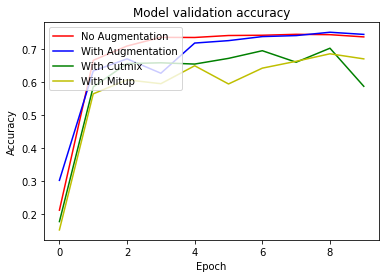

In [55]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','With Cutmix','With Mitup'
           ], loc='upper left')
plt.show()

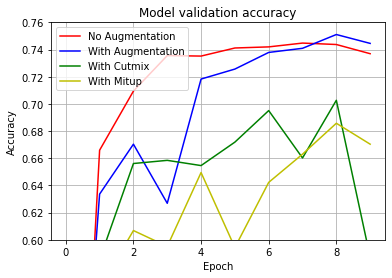

In [56]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','With Cutmix','With Mitup'
           ], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석

### Epoch 10 로 학습시켜보았다.
- 정확도 순서대로 Augmentation > No Aug > Mixup > Cutmix
- Aug VS No Aug : Aug한 결과가 확실히 더 다양한 데이터셋을 가지고 있기 때문에 정확도가 좋았다.
- Cutmix & MIxup : 두 방법을 사용하면 이미지의 결과가 정확히 분류하기 힘들다.Ex) 개머리 + 고양이 몸통 , 고양이 머리 + 개 몸통 . 따라서 정확도가 현저히 떨어진 것으로 보인다.
- 하지만 Epoch를 올리면 지금보다 더 좋아지긴 하겠지만, 크게 성능이 좋아질 것이라 보이진 않는다..